AutoEncoder

In [1]:
# importing all the required libraries
import os, gc, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# defining the path to image files in google cloud
path0 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00'
path1 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_01'
path2 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_02'
path3 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_03'
path4 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_04'
path5 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_05'
path6 = '/content/drive/MyDrive/Colab Notebooks/cats/CAT_06'

import cv2
import os

# function load_images_from_folder will initialize our image list holding N-dimensional arrays corresponding to all the images 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(os.path.join(folder,filename))
    return images

Generating image arrays in list named images and appending images from all the image folders

In [3]:
images = load_images_from_folder(path0)

In [4]:
images = images + (load_images_from_folder(path1)) + (load_images_from_folder(path2)) + (load_images_from_folder(path3)) + (load_images_from_folder(path4)) + (load_images_from_folder(path5)) + (load_images_from_folder(path6))

In [ ]:
images

['/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000379_011.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000378_010.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000379_003.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000378_026.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000379_029.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000381_015.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_023.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_021.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000381_020.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_003.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_024.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000381_009.jpg',
 '/content/drive/MyDrive/Colab Notebooks/cats/CAT_00/00000380_00

Cropping all the images and saving it in seperate folder

In [7]:
from PIL import Image
i=0
for imag in images:
  img = Image.open(imag)
  img = img.resize(( 100,int(img.size[1]/(img.size[0]/100) )),Image.ANTIALIAS)
  w = img.size[0]
  h = img.size[1]
  a,b = 0,0
  if w>64:
    a = np.random.randint(0, w-64)
  if h>64:
    b = np.random.randint(0, h-64)
  img = img.crop((a,b,64+a,64+b))
  img.save('/content/drive/MyDrive/Colab Notebooks/cats/images/image_folder/'+str(i)+'.png', 'PNG')
  i+=1

Creating Train Dataset for AutoEncoders

In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

BATCH_SIZE = 256; EPOCHS = 5
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/cats/images',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 9997 images belonging to 1 classes.


Creating AutoEncoder and Compiling it

In [9]:
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

Loss after Each Epoch

In [10]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                                     epochs = EPOCHS, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
39/39 - 828s - loss: 0.6278 - 828s/epoch - 21s/step
Epoch 2/5
39/39 - 818s - loss: 0.5631 - 818s/epoch - 21s/step
Epoch 3/5
39/39 - 812s - loss: 0.5510 - 812s/epoch - 21s/step
Epoch 4/5
39/39 - 809s - loss: 0.5439 - 809s/epoch - 21s/step
Epoch 5/5
39/39 - 805s - loss: 0.5421 - 805s/epoch - 21s/step


Creating Re-constructed image and comparing it with original one

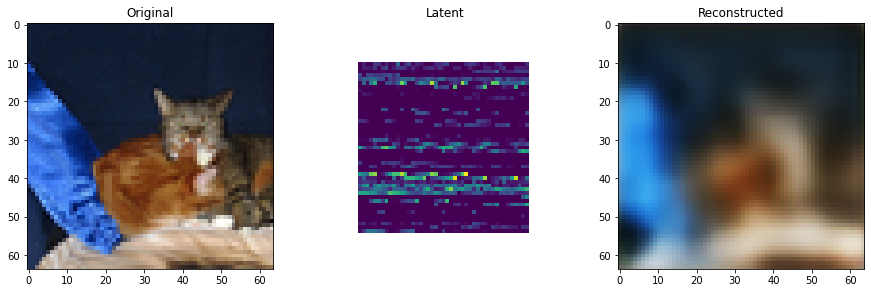

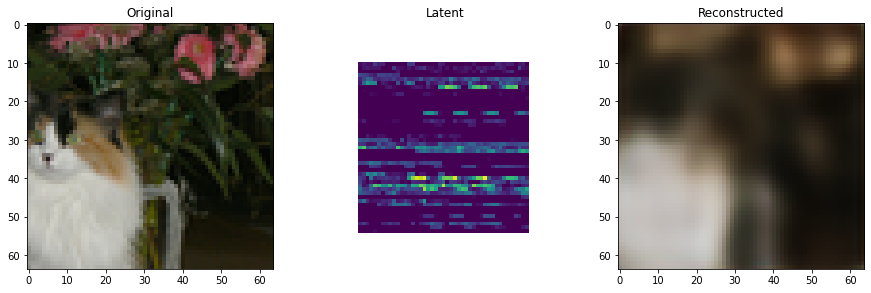

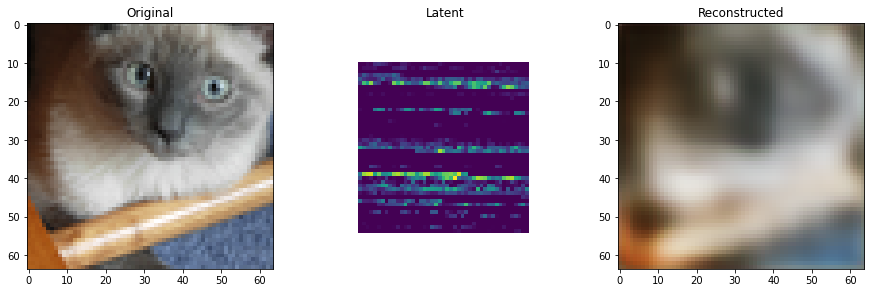

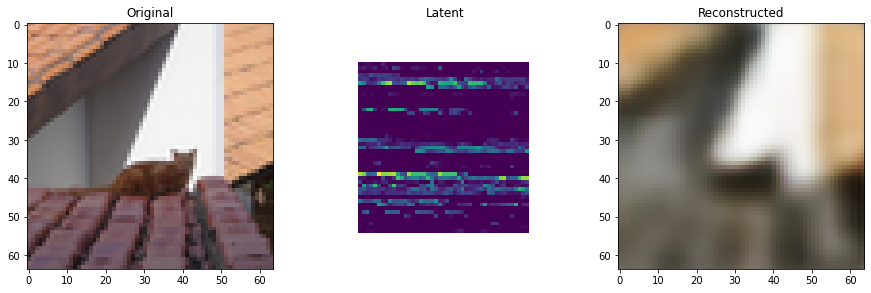

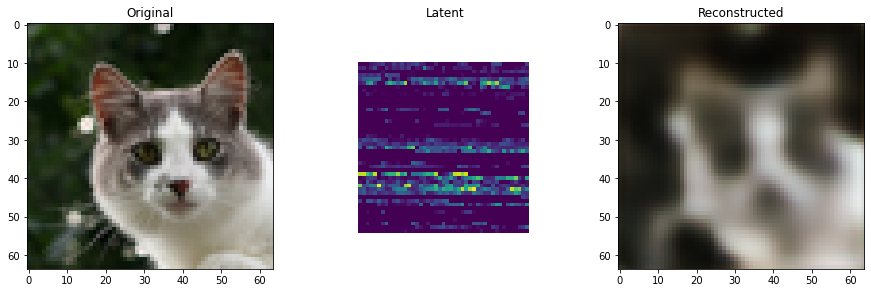

In [11]:

images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

In [12]:
images = (load_images_from_folder(path0)) + (load_images_from_folder(path1)) + (load_images_from_folder(path2)) + (load_images_from_folder(path3)) + (load_images_from_folder(path4)) + (load_images_from_folder(path5)) + (load_images_from_folder(path6))

In [13]:
len(images)

9997

Generating Cat images using the AutoEncoder

In [14]:
# CREATE CROPPED IMAGES
x = np.random.choice(np.arange(20000),10000)
Images = np.zeros((len(images),64,64,3))
i=0
for imag in images:
    img = Image.open(imag)
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    Images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    i+=1
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM IMAGES        
encoded_imgs = encoder.predict(Images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 9 RANDOM CAT IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

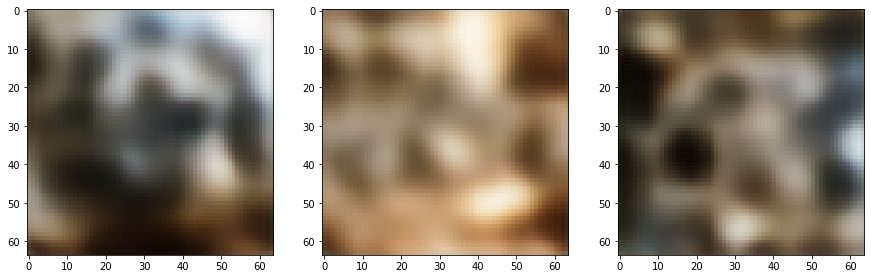

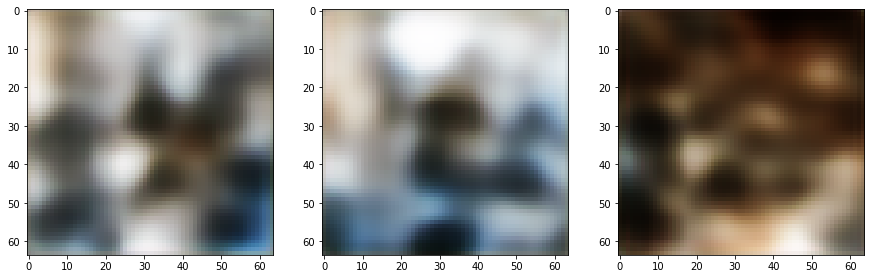

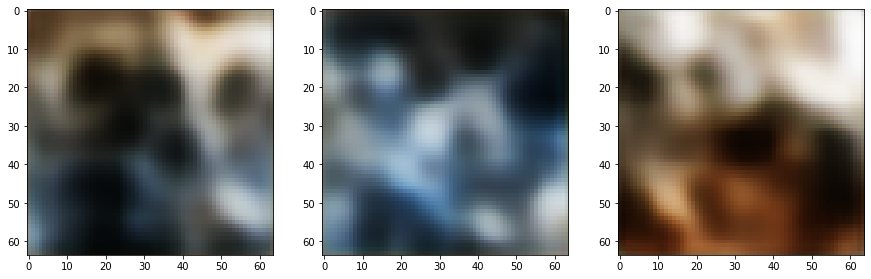

In [15]:
# PLOT 9 RANDOM CAT IMAGES
for k in range(3):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

Creating 45 random images

In [16]:
# CREATE 10000 CROPPED IMAGES
Images = np.zeros((len(images),64,64,3))
i=0
for imag in images:
    img = Image.open(imag)
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    Images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    i+=1
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM IMAGES        
encoded_imgs = encoder.predict(Images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 45 RANDOM CAT IMAGES
generated = np.random.multivariate_normal(mm,ss,45)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

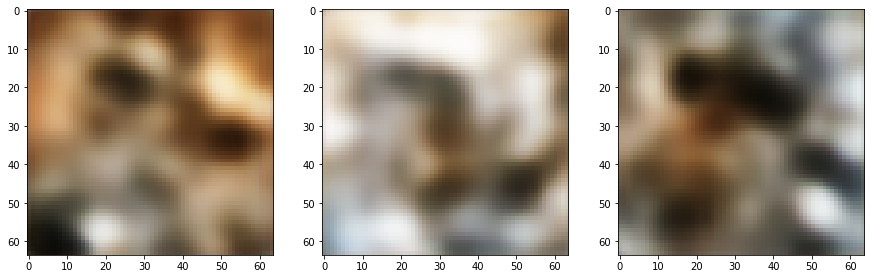

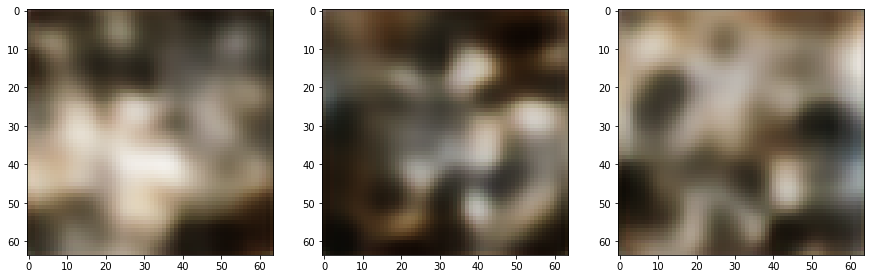

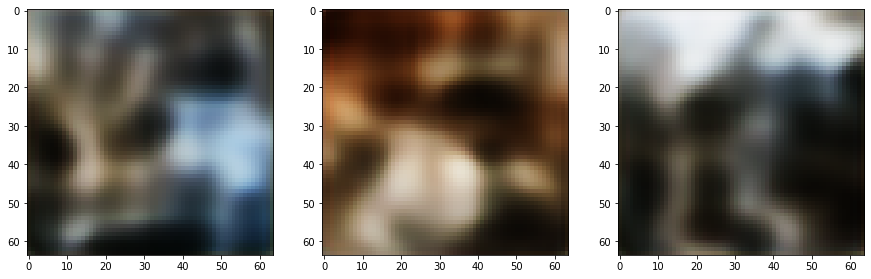

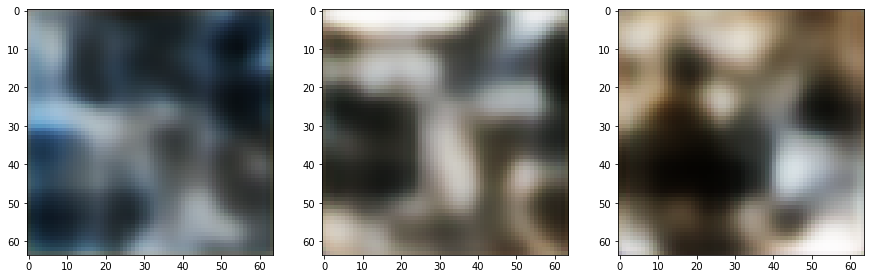

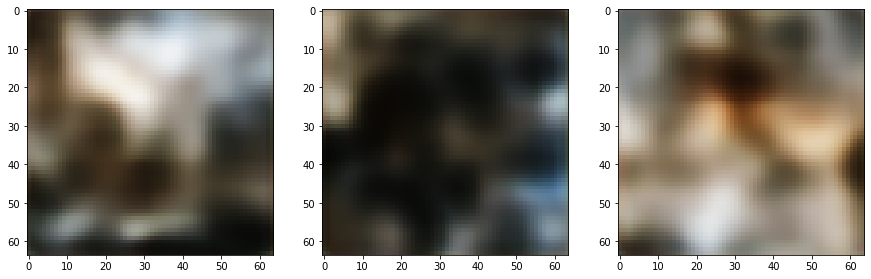

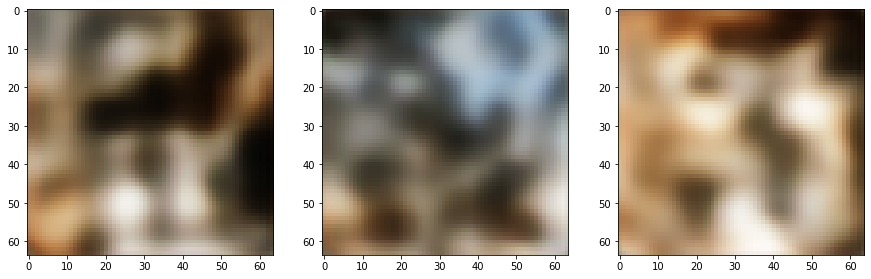

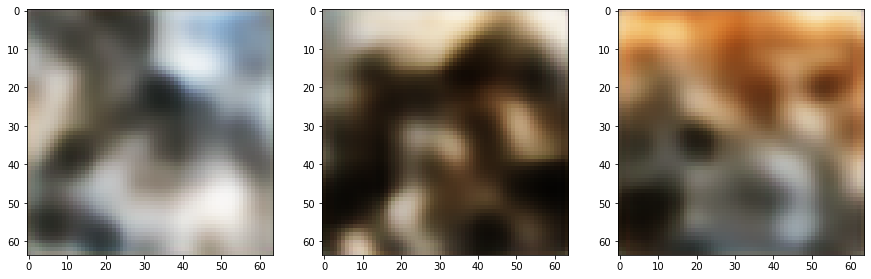

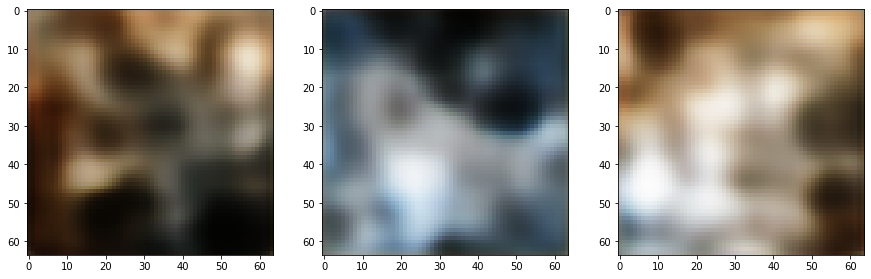

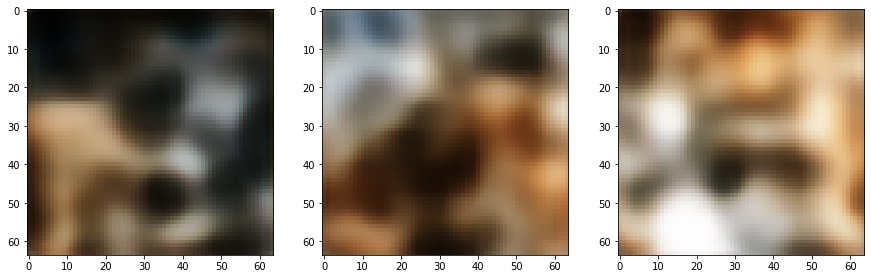

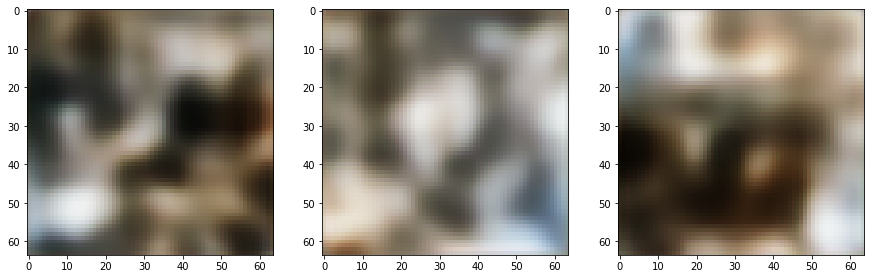

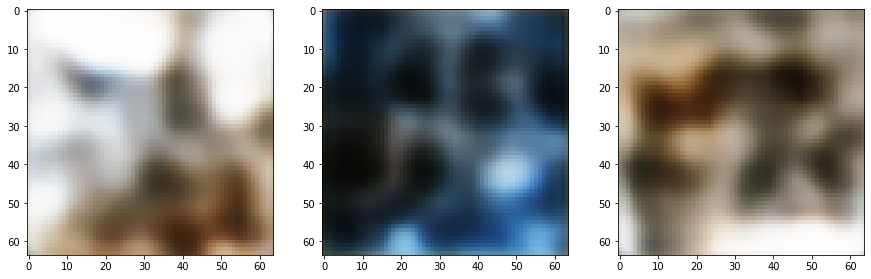

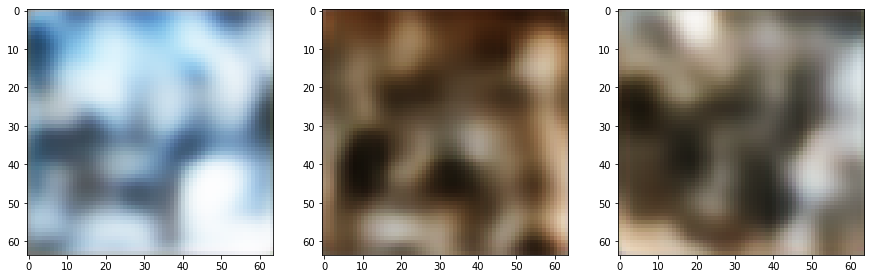

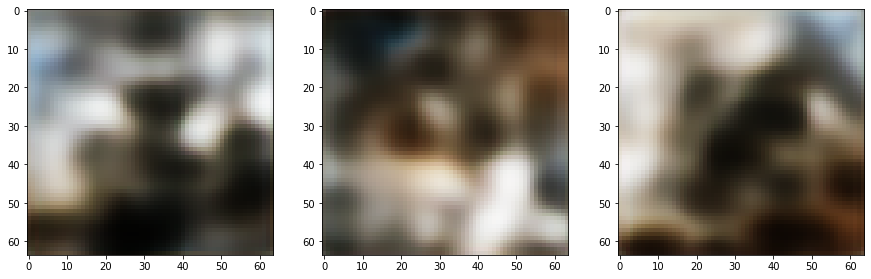

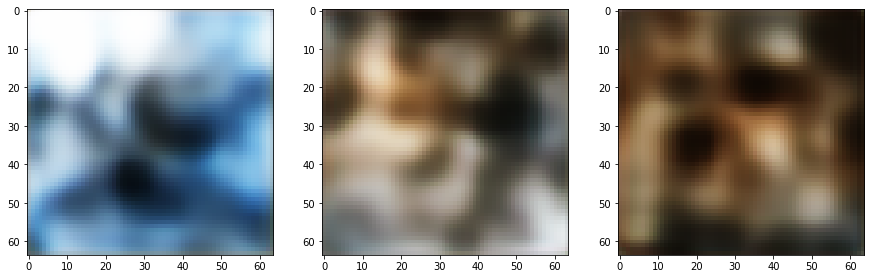

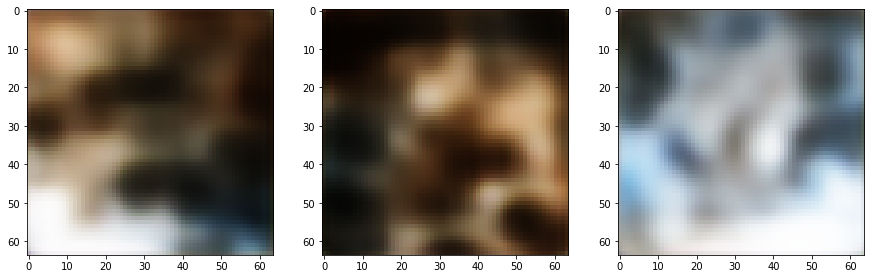

In [17]:
# PLOT 45 RANDOM CAT IMAGES
for k in range(15):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

Changing latent size and network architecture for AutoEncoders

In [18]:
# ENCODER
import tensorflow as tf
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation=tf.nn.leaky_relu, padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (16,16,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation=tf.nn.leaky_relu, padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

Checking loss per Epoch

In [19]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                                     epochs = EPOCHS, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
39/39 - 1123s - loss: 0.5968 - 1123s/epoch - 29s/step
Epoch 2/5
39/39 - 1213s - loss: 0.5397 - 1213s/epoch - 31s/step
Epoch 3/5
39/39 - 1160s - loss: 0.5342 - 1160s/epoch - 30s/step
Epoch 4/5
39/39 - 1111s - loss: 0.5313 - 1111s/epoch - 28s/step
Epoch 5/5
39/39 - 1137s - loss: 0.5293 - 1137s/epoch - 29s/step


Generating Re-Constructed image and comparing it with original one

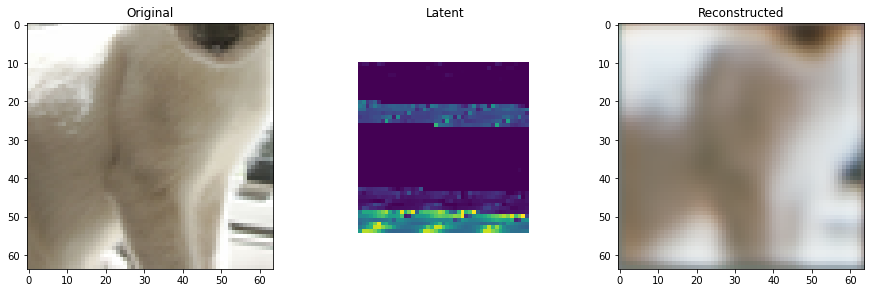

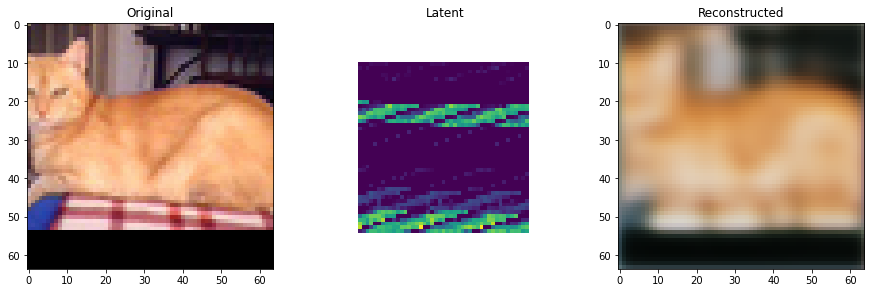

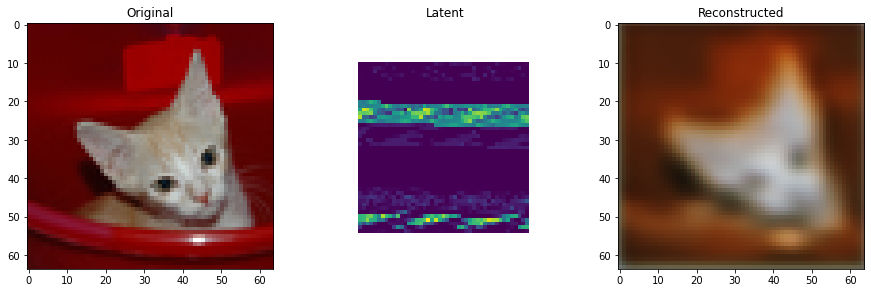

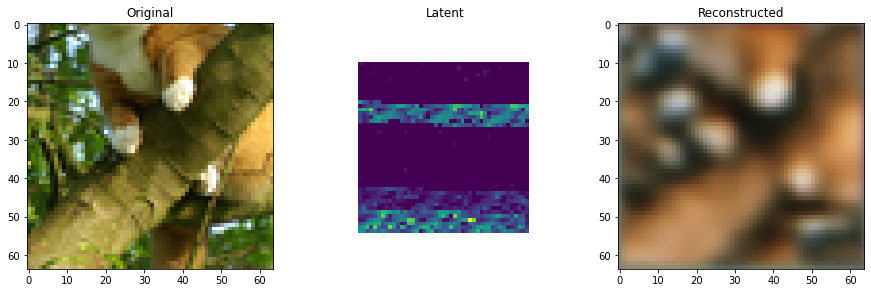

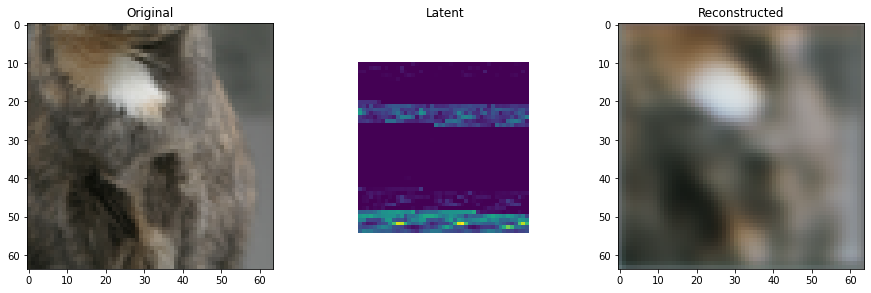

In [ ]:
Images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = Images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

In [ ]:
images = (load_images_from_folder(path0)) + (load_images_from_folder(path1)) + (load_images_from_folder(path2)) + (load_images_from_folder(path3)) + (load_images_from_folder(path4)) + (load_images_from_folder(path5)) + (load_images_from_folder(path6))

In [ ]:
# CREATE CROPPED IMAGES
x = np.random.choice(np.arange(20000),10000)
Images = np.zeros((len(images),64,64,3))
i=0
for imag in images:
    img = Image.open(imag)
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    Images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    i+=1
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM IMAGES        
encoded_imgs = encoder.predict(Images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 45 RANDOM CAT IMAGES
generated = np.random.multivariate_normal(mm,ss,45)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

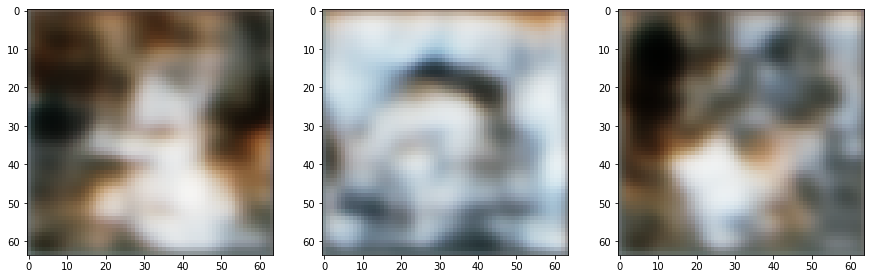

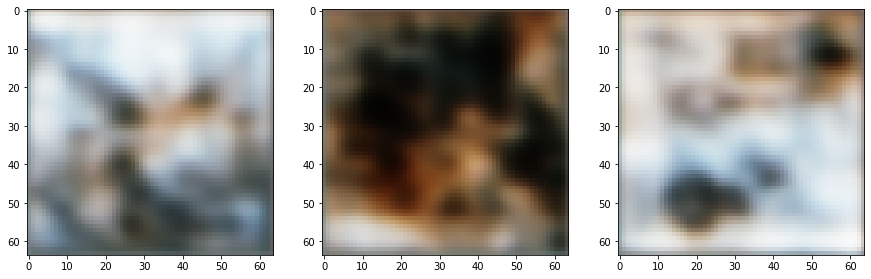

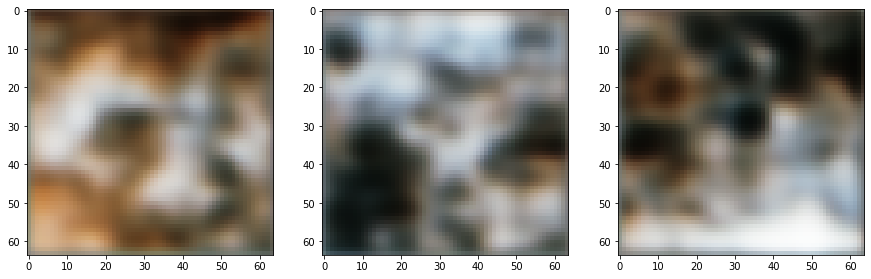

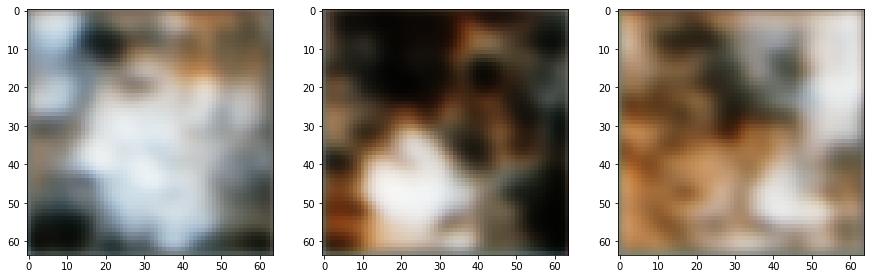

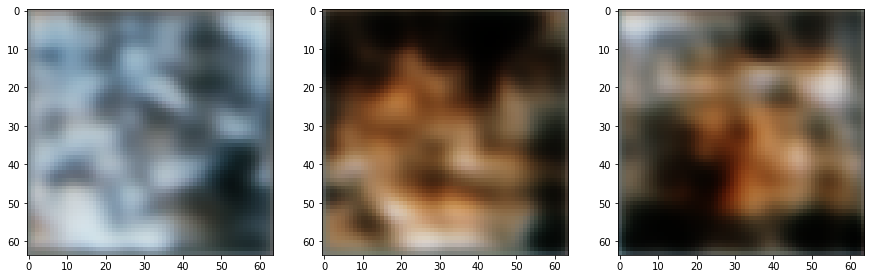

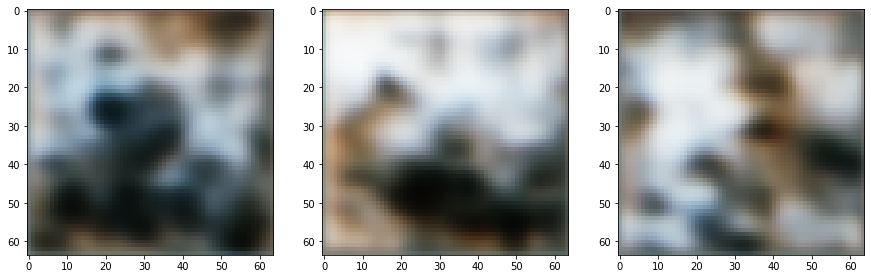

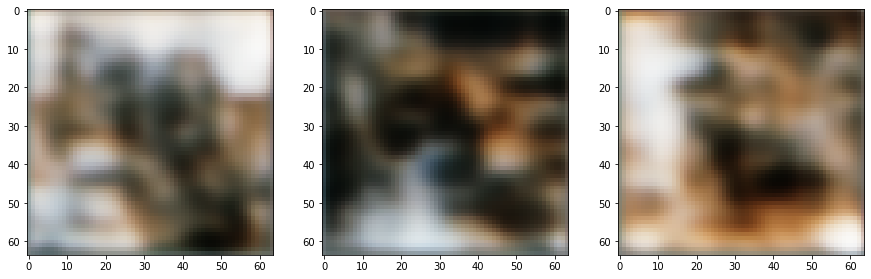

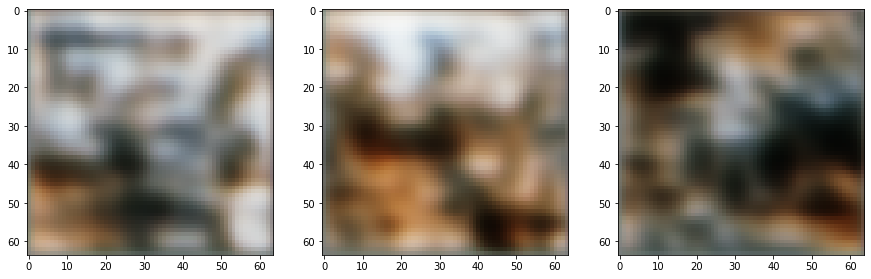

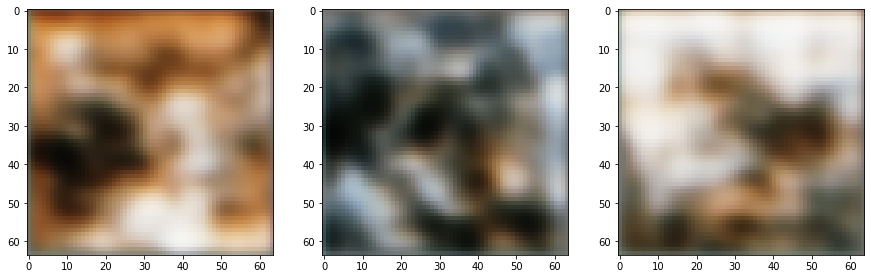

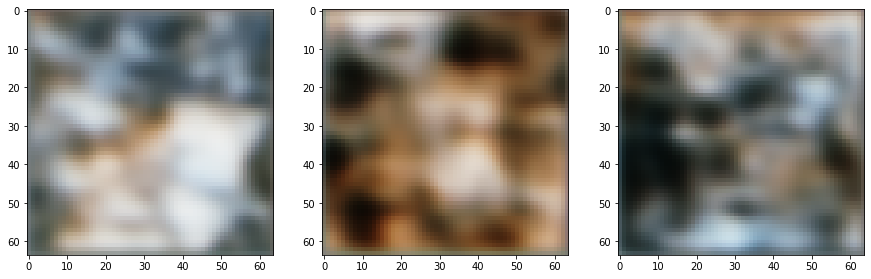

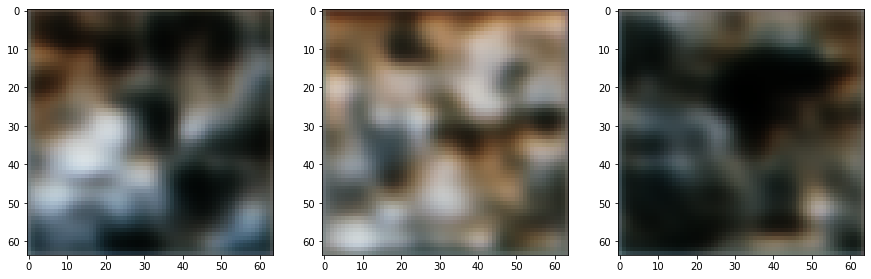

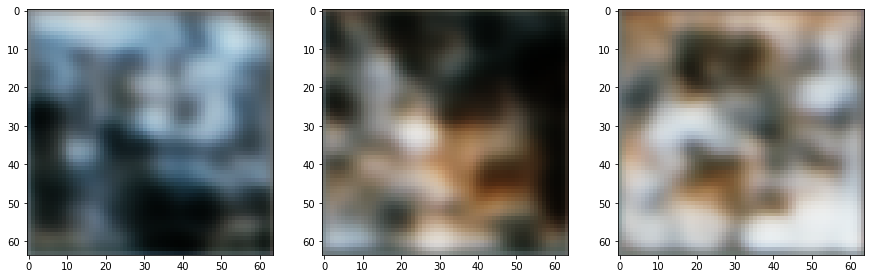

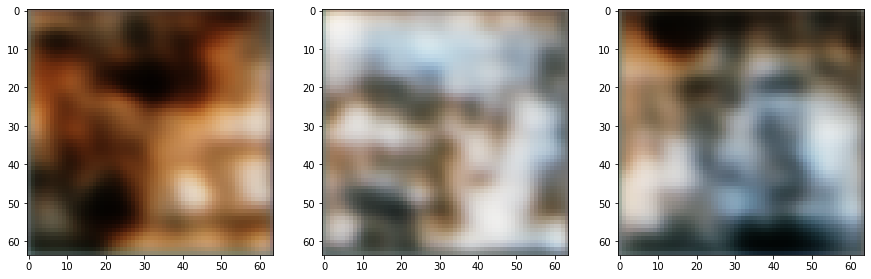

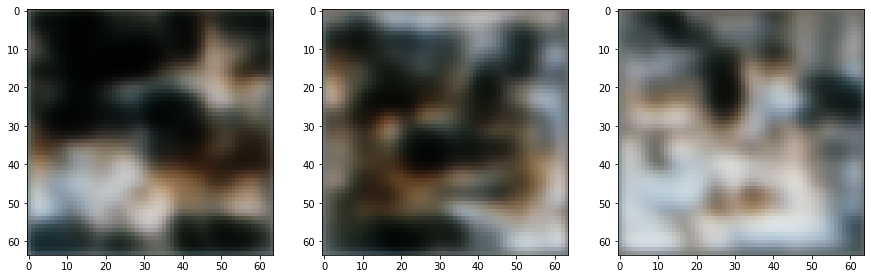

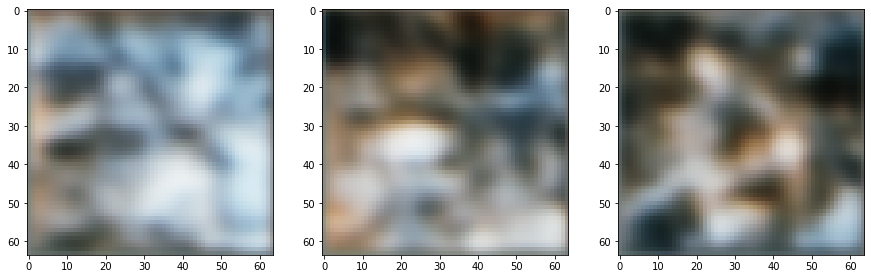

In [ ]:
# PLOT 45 RANDOM CAT IMAGES
for k in range(15):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

In [5]:
lossa = [0.6278,0.5631, 0.5510, 0.5439, 0.5421]
lossb=[0.5968,0.5397, 0.5418, 0.5342, 0.5313]

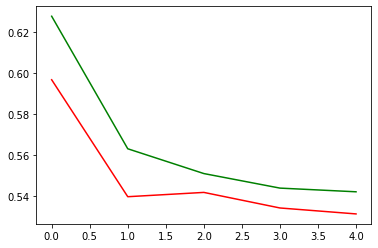

In [6]:
import matplotlib.pyplot as plt
plt.plot(lossa, color='g')
plt.plot(lossb, color='r')

# Conclusion :-
It is clearly visible that the loss after changing the latent size and network architecture reduces. The red line shows that even though after reducing the number of layers but if we change the latent size  we can achieve a good efficiency for autoencoder

Variational Auto Encoder

In [ ]:
# ENCODER
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation=tf.nn.leaky_relu, padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (16,16,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation=tf.nn.leaky_relu, padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
#vae = Model(input_img, decoder(encoded))

#vae.compile(optimizer='Adam', loss='binary_crossentropy')

In [ ]:
vae_input = tf.keras.layers.Input(shape=(64, 64, 3), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 64, 64, 3)]       0         
                                                                 
 model_8 (Functional)        (None, 16, 16, 32)        46016     
                                                                 
 model_9 (Functional)        (None, 64, 64, 3)         422595    
                                                                 
Total params: 468,611
Trainable params: 468,611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae.compile(optimizer='Adam', loss='binary_crossentropy')

In [ ]:
history = vae.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                                     epochs = EPOCHS, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
6/6 - 5s - loss: 0.6778 - 5s/epoch - 823ms/step
Epoch 2/5
6/6 - 4s - loss: 0.6126 - 4s/epoch - 686ms/step
Epoch 3/5
6/6 - 4s - loss: 0.5759 - 4s/epoch - 643ms/step
Epoch 4/5
6/6 - 4s - loss: 0.5619 - 4s/epoch - 678ms/step
Epoch 5/5
6/6 - 4s - loss: 0.5547 - 4s/epoch - 673ms/step


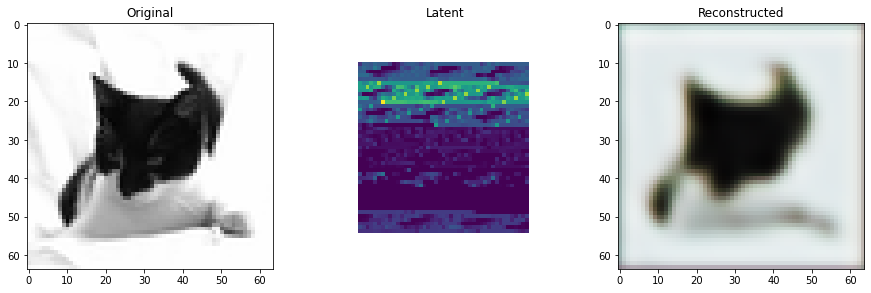

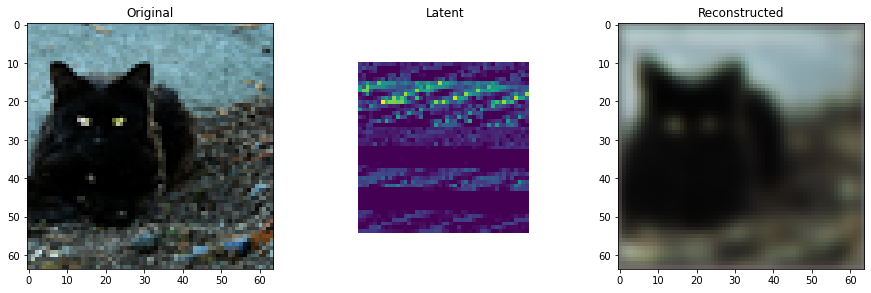

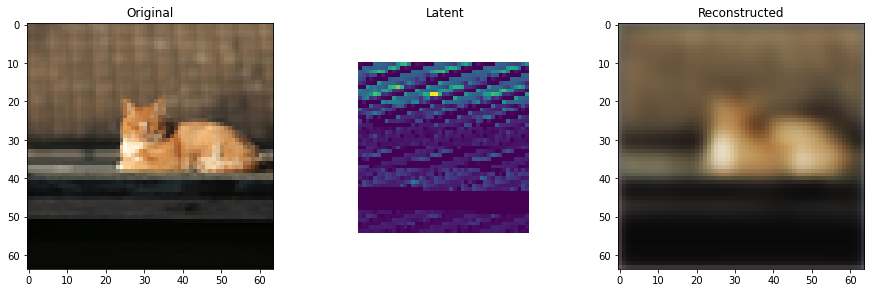

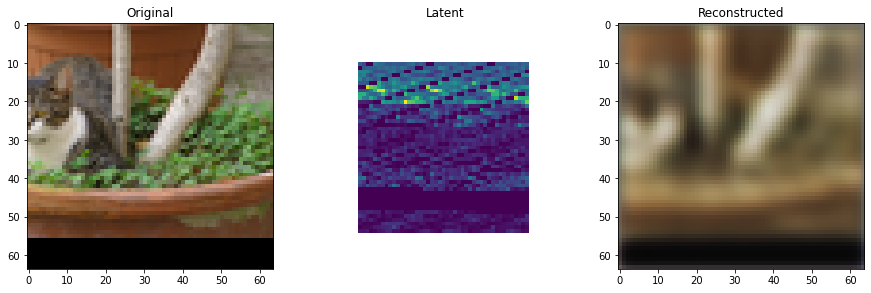

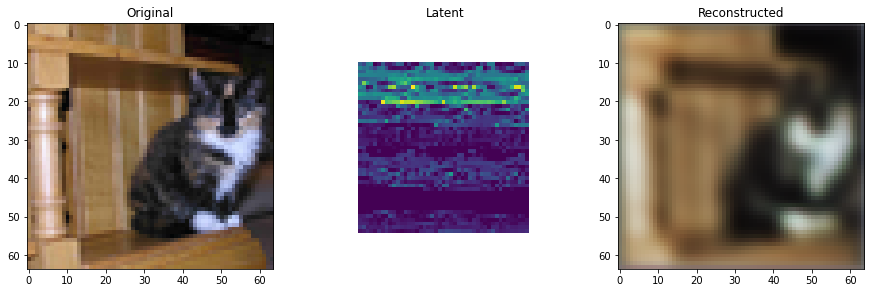

In [ ]:
Images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = Images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = vae.predict(orig[0].reshape((-1,64,64,3)))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

Changing latent size network architecture for VAE

In [ ]:
im_batch_size = 10
n_images=40
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Colab Notebooks/cats/output_images_vae', f'image_{i_batch+i_image:05d}.png'))


In [20]:
# ENCODER
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
#vae = Model(input_img, decoder(encoded))

#vae.compile(optimizer='Adam', loss='binary_crossentropy')

In [21]:
vae_input = tf.keras.layers.Input(shape=(64, 64, 3), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 64, 64, 3)]       0         
                                                                 
 model_6 (Functional)        (None, 8, 8, 32)          215168    
                                                                 
 model_7 (Functional)        (None, 64, 64, 3)         547107    
                                                                 
Total params: 762,275
Trainable params: 762,275
Non-trainable params: 0
_________________________________________________________________


In [22]:
vae.compile(optimizer='Adam', loss='binary_crossentropy')

In [23]:
history = vae.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                                     epochs = EPOCHS, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
39/39 - 811s - loss: 0.6073 - 811s/epoch - 21s/step
Epoch 2/5
39/39 - 800s - loss: 0.5548 - 800s/epoch - 21s/step
Epoch 3/5
39/39 - 801s - loss: 0.5459 - 801s/epoch - 21s/step
Epoch 4/5
39/39 - 804s - loss: 0.5420 - 804s/epoch - 21s/step
Epoch 5/5
39/39 - 803s - loss: 0.5399 - 803s/epoch - 21s/step


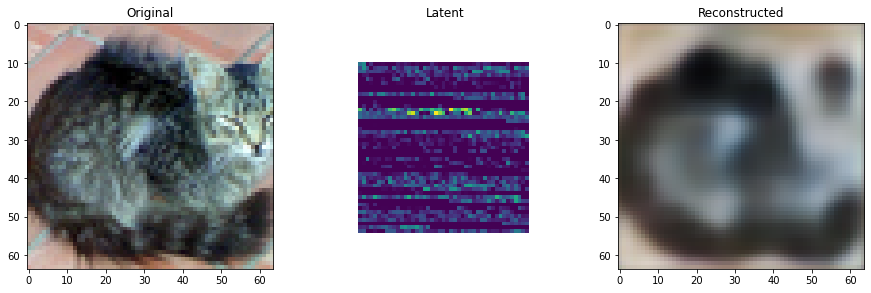

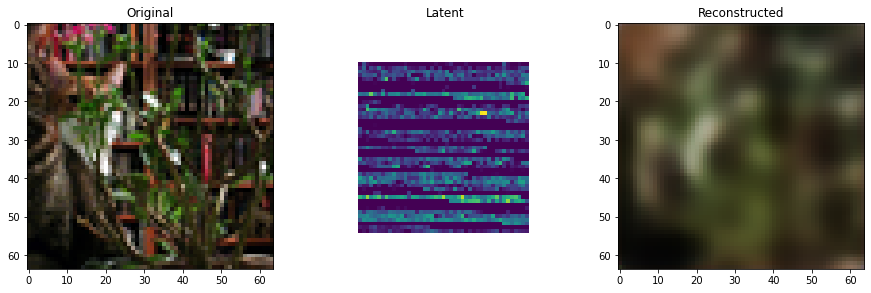

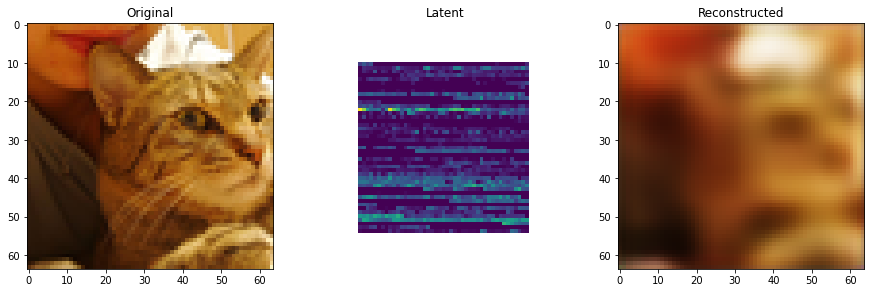

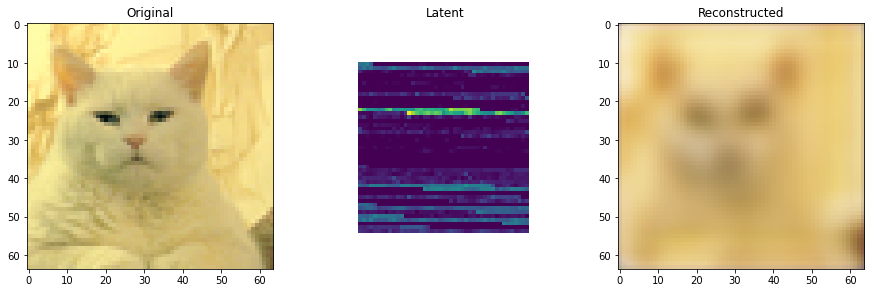

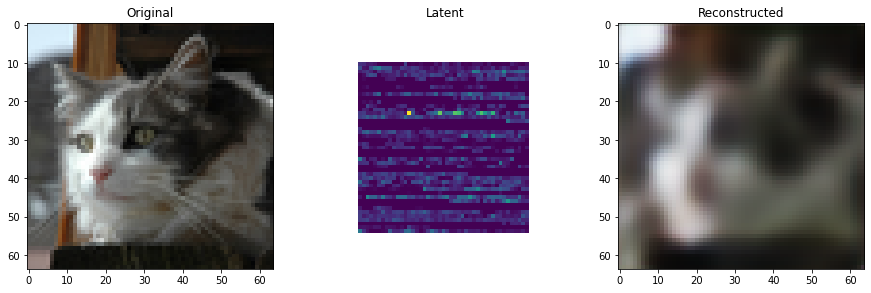

In [24]:
Images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = Images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = vae.predict(orig[0].reshape((-1,64,64,3)))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

In [25]:
images = (load_images_from_folder(path0)) + (load_images_from_folder(path1)) + (load_images_from_folder(path2)) + (load_images_from_folder(path3)) + (load_images_from_folder(path4)) + (load_images_from_folder(path5)) + (load_images_from_folder(path6))

In [ ]:
# CREATE CROPPED IMAGES
x = np.random.choice(np.arange(20000),10000)
Images = np.zeros((len(images),64,64,3))
i=0
for imag in images:
    img = Image.open(imag)
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    Images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    i+=1
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM IMAGES        
encoded_imgs = vae.predict(Images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 45 RANDOM CAT IMAGES
generated = np.random.multivariate_normal(mm,ss,45)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

In [ ]:
im_batch_size = 10
n_images=40
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Colab Notebooks/cats/modified_output_images_vae', f'image_{i_batch+i_image:05d}.png'))


In [7]:
lossa = [0.6778, 0.5926, 0.5759, 0.5619, 0.5547]
lossb=[0.6073, 0.5548, 0.5459, 0.5420, 0.5339]

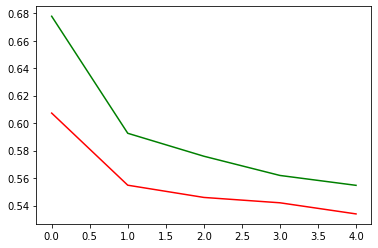

In [8]:
plt.plot(lossa, color='g')
plt.plot(lossb, color='r')

# Conclusion :-
It is clearly visible that the loss after changing the latent size and network architecture reduces. The red line shows that even though after reducing the number of layers but if we change the latent size  we can achieve a good efficiency for variational autoencoder

GANS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

batch_size = 32

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/cats/images/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)
        # state size. (nchannels) x 64 x 64

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0
batch_size = train_loader.batch_size
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [ ]:

epochs = 5

step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')


[1/5][0/54] Loss_D: 1.4390 Loss_G: 3.7830 D(x): 0.5416 D(G(z)): 0.5382 / 0.0155


In [ ]:
im_batch_size = 10
n_images=40
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Colab Notebooks/cats/output_images', f'image_{i_batch+i_image:05d}.png'))


Changing the latent size and Network Architecture for GAN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

batch_size = 32

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/cats/images/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        #self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
       # self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)
        # state size. (nchannels) x 64 x 64

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        #self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        #self.bn4 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        #x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0
batch_size = train_loader.batch_size
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [ ]:

epochs = 5

step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

[1/5][0/54] Loss_D: 1.3838 Loss_G: 3.6849 D(x): 0.5169 D(G(z)): 0.5013 / 0.0173


In [ ]:
im_batch_size = 10
n_images=40
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/Colab Notebooks/cats/modified_output_images', f'image_{i_batch+i_image:05d}.png'))


# Conclusion :-
It is clearly visible that the loss after changing the latent size and network architecture reduces. The red line shows that even though after reducing the number of layers but if we change the latent size and activation function we cannot predict the efficiency for Gans, but may be if the epochs are increased we can get a good picture.

<h1><b>License</b></h1>

Copyright 2022 Abhishek Jaiswal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.